# Proyecto Final : Airline Passenger Satisfaction

# Parte 2: Regresión Logística

#### Realizado por Javier Gómez Moraleda y Unai Piris Ibañez

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import seaborn as sebrn

from pandas.io.parsers import read_csv
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Carga de datos

In [2]:
def load_csv(file_name):
    # CSV to DataFrame
    data = read_csv(file_name).to_numpy()
    return data[:,1:]

In [3]:
# Cargamos los ficheros procesados
train = load_csv('data/processed/train_processed.csv')
validation = load_csv('data/processed/validation_processed.csv')
test = load_csv('data/processed/test_processed.csv')

In [4]:
# Dividimos entre las columnas de datos y la predicción
X_train = train[:,:-1]
y_train = train[:,-1]
X_validation = validation[:,:-1]
y_validation = validation[:,-1]
X_test = test[:,:-1]
y_test = test[:,-1]

## Regresión logística sin regularización

In [5]:
# Calcula el valor de la función sigmoide
def sigmoid(X):
    z = 1/(1 + np.exp(-X))
    return z

In [6]:
# Calcula la función de coste
def fun_coste (thetas, X, y):
    
    H = sigmoid(np.dot(X, thetas))
    Term1 = np.matmul(y, np.log(H))
    Term2 = np.matmul((1 - y), np.log(1 - H))
    cost = (- 1 / (len(y))) * np.sum(Term1 + Term2)
    
    return cost

In [7]:
# Calcula el gradiente
def gradient(thetas, X, Y):
    H = sigmoid(np.dot(X, thetas))
    Dif = H - Y
    grad = (1 / len(Y)) * np.matmul(Dif, X)

    return grad

In [8]:
# Calcula la predicción
def predict(X, Y, theta_opt):
    Y_prediccion = np.round(sigmoid(np.dot(X, theta_opt)))
    return Y_prediccion

In [9]:
# Calcula la precisión
def accuracy(Y, Y_prediccion, m):
    return np.sum((Y == np.array(Y_prediccion))) / m

In [10]:
# Añadimos una columna de 1's
X_train_1 = np.hstack([np.ones([np.shape(X_train)[0], 1]), X_train])

# Filas y columnas
m = np.shape(X_train_1)[0]
n = np.shape(X_train_1)[1]

# Calculamos valores de thetas óptimos
thetas = np.zeros(n)
result = opt.fmin_tnc(func=fun_coste, x0=thetas, fprime=gradient, args=(X_train_1, y_train))
theta_opt = result[0]

In [11]:
# Porcentaje de aciertos sobre el conjunto de test
X_test_1 = np.hstack([np.ones([np.shape(X_test)[0], 1]), X_test])
y_test_pred = predict(X_test_1, y_test, theta_opt)
hits = accuracy(y_test, y_test_pred, np.shape(X_test_1)[0])
print("Porcentaje acertado: ", hits * 100, "%")

Porcentaje acertado:  86.5 %


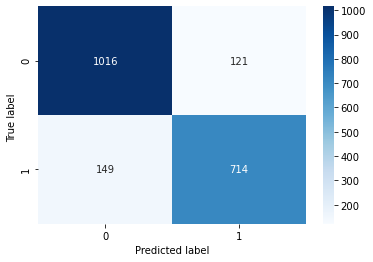

In [12]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Using Seaborn heatmap to create the plot
fx = sebrn.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')

# labels the title and x, y axis of plot
fx.set_xlabel('Predicted label')
fx.set_ylabel('True label ');

plt.savefig('figures/parte2/confusion_matrix_linear.png')

In [13]:
# Accuracy, precision, recall and f1
target_names = ['neutral or dissatisfied', 'satisfied']
print(classification_report(y_test_pred, y_test, target_names=target_names))

                         precision    recall  f1-score   support

neutral or dissatisfied       0.89      0.87      0.88      1165
              satisfied       0.83      0.86      0.84       835

               accuracy                           0.86      2000
              macro avg       0.86      0.86      0.86      2000
           weighted avg       0.87      0.86      0.87      2000



## Regresión logística regularizada

In [14]:
# Calcula la función de coste regularizada
def fun_coste_reg(thetas, X, Y, lam):
    H = sigmoid(np.dot(X, thetas))
    m = len(Y)
    Term1 = np.matmul(Y, np.log(H))
    Term2 = np.matmul((1 - Y), np.log(1 - H))
    cost = (- np.sum(Term1 + Term2) / m)  + (lam / (2*m)) * np.sum(np.square(thetas))
    
    return cost

In [15]:
# Calcula el gradiente
def gradient_reg(thetas, X, Y, lam):
    H = sigmoid(np.dot(X, thetas))
    m = len(Y)
    Dif = H - Y
    grad = (np.matmul(Dif, X) / m)  + (lam / m) * thetas

    return grad

In [16]:
# Probamos distintos valores de lambda
lamlist = [0.00001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
scores = []

In [17]:
# Añadimos una columna de 1's
X_train_1 = np.hstack([np.ones([np.shape(X_train)[0], 1]), X_train])
X_validation_1 = np.hstack([np.ones([np.shape(X_validation)[0], 1]), X_validation])

# Filas y columnas
m = np.shape(X_train_1)[0]
n = np.shape(X_train_1)[1]

# Iterando diferentes valores de lambda
for lam in lamlist:   
    thetas = np.zeros(n)
    result = opt.fmin_tnc(func=fun_coste_reg, x0=thetas, fprime=gradient_reg, args=(X_train_1, y_train, lam))
    theta_opt = result[0]
    hits = accuracy(y_validation, predict(X_validation_1, y_validation, theta_opt), m)
    scores.append(hits*100)

In [18]:
# Matriz de porcentajes de aciertos obtenida
print(scores)

[29.56666666666667, 29.56666666666667, 29.56666666666667, 29.56666666666667, 29.56666666666667, 29.56666666666667, 29.56666666666667, 29.51666666666667, 29.45]


In [19]:
# Obtenemos los índices de los valores máximos
indexes = np.where(scores == np.amax(scores))
print(indexes)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int64),)


In [20]:
# Nos quedamos con el primer valor máximo que aparece
lam_max_index = indexes[0][0]
lam_max = lamlist[lam_max_index]

In [21]:
# Porcentaje de aciertos sobre el conjunto de test
X_test_1 = np.hstack([np.ones([np.shape(X_test)[0], 1]), X_test])
y_test_pred = predict(X_test_1, y_test, theta_opt)
hits = accuracy(y_test, y_test_pred, np.shape(X_test_1)[0])
print("Lambda: ", lam_max, " Porcentaje acertado: ", hits * 100, "%")

Lambda:  1e-05  Porcentaje acertado:  86.3 %


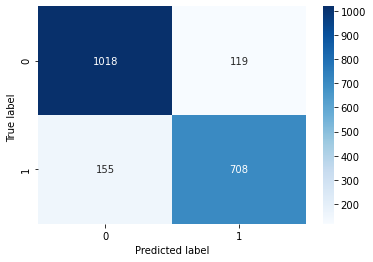

In [22]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Using Seaborn heatmap to create the plot
fx = sebrn.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')

# labels the title and x, y axis of plot
fx.set_xlabel('Predicted label')
fx.set_ylabel('True label ');

plt.savefig('figures/parte2/confusion_matrix_reg.png')

In [23]:
# Accuracy, precision, recall and f1
target_names = ['neutral or dissatisfied', 'satisfied']
print(classification_report(y_test_pred, y_test, target_names=target_names))

                         precision    recall  f1-score   support

neutral or dissatisfied       0.90      0.87      0.88      1173
              satisfied       0.82      0.86      0.84       827

               accuracy                           0.86      2000
              macro avg       0.86      0.86      0.86      2000
           weighted avg       0.86      0.86      0.86      2000

